In [76]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import norm
import matplotlib.pyplot as plt

# ----------------------------
# Load and prepare data
# ----------------------------
def load_data(file_path):
    data = pd.read_csv(file_path)
    X = data[['time', 'temp', 'sulf', 'anly']].values
    y = data['yield product'].values
    return X, y

# ----------------------------
# Acquisition functions
# ----------------------------
def expected_improvement(mu, sigma, f_best):
    sigma = sigma + 1e-9  # avoid division by zero
    Z = (mu - f_best) / sigma
    ei = (mu - f_best) * norm.cdf(Z) + sigma * norm.pdf(Z)
    return ei

def upper_confidence_bound(mu, sigma, kappa=2.0):
    return mu + kappa * sigma

def probability_of_improvement(mu, sigma, f_best):
    sigma = sigma + 1e-9
    Z = (mu - f_best) / sigma
    return norm.cdf(Z)

# ----------------------------
# Run a single BO loop
# ----------------------------
def run_bo_loop(X_pool, y_pool, model, n_iterations=20, init_size=5, acq_func='ei', seed=42):
    np.random.seed(seed)
    init_idx = np.random.choice(range(len(X_pool)), size=init_size, replace=False)
    X_train = X_pool[init_idx]
    y_train = y_pool[init_idx]
    mask = np.ones(len(X_pool), dtype=bool)
    mask[init_idx] = False
    X_test = X_pool[mask]
    y_test = y_pool[mask]
    
    best_so_far = []

    for i in range(n_iterations):
        model.fit(X_train, y_train)

        if isinstance(model, GaussianProcessRegressor):
            mu, sigma = model.predict(X_test, return_std=True)
        elif isinstance(model, RandomForestRegressor):
            all_preds = np.stack([tree.predict(X_test) for tree in model.estimators_], axis=0)
            mu = np.mean(all_preds, axis=0)
            sigma = np.std(all_preds, axis=0)
        elif isinstance(model, GradientBoostingRegressor):
            all_preds = np.stack([est[0].predict(X_test) for est in model.estimators_], axis=0)
            mu = np.mean(all_preds, axis=0)
            sigma = np.std(all_preds, axis=0)
        else:
            raise ValueError("Unsupported model type")

        # Apply selected acquisition function
        if acq_func == 'ei':
            acq_values = expected_improvement(mu, sigma, y_train.max())
        elif acq_func == 'ucb':
            acq_values = upper_confidence_bound(mu, sigma, kappa=2.0)
        elif acq_func == 'pi':
            acq_values = probability_of_improvement(mu, sigma, y_train.max())
        else:
            raise ValueError(f"Unsupported acquisition function: {acq_func}")

        next_idx = np.argmax(acq_values)

        X_train = np.vstack([X_train, X_test[next_idx]])
        y_train = np.append(y_train, y_test[next_idx])
        X_test = np.delete(X_test, next_idx, axis=0)
        y_test = np.delete(y_test, next_idx, axis=0)

        best_so_far.append(y_train.max())

    return best_so_far


# ----------------------------
# Run multiple BO runs (averaging)
# ----------------------------
def run_multiple_bo(X_pool, y_pool, model, n_runs=10, n_iterations=20, acq_func='ei'):
    all_runs = []
    for seed in range(n_runs):
        best_so_far = run_bo_loop(X_pool, y_pool, model, n_iterations=n_iterations, acq_func=acq_func, seed=seed)
        all_runs.append(best_so_far)
    return np.array(all_runs)

# ----------------------------
# Plot results
# ----------------------------
def plot_results_besty(results_dict, n_iterations):
    plt.figure(figsize=(10, 6))
    for model_name, runs in results_dict.items():
        mean_curve = np.mean(runs, axis=0)
        std_curve = np.std(runs, axis=0)
        plt.plot(mean_curve, label=f'{model_name} (avg)')
        plt.fill_between(range(n_iterations),
                         mean_curve - std_curve,
                         mean_curve + std_curve,
                         alpha=0.2)
    plt.xlabel('Iteration')
    plt.ylabel('Best Yield Found')
    plt.title('Average BO Performance Across Runs')
    plt.legend()
    plt.grid(True)
    plt.show()


Running Gaussian Process BO...
Running Random Forest BO...
Running Gradient Boosting BO...


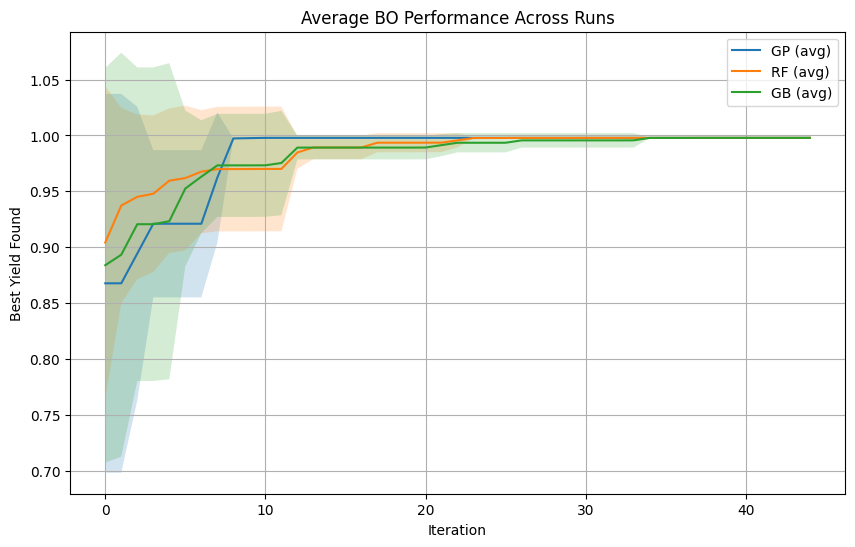

In [77]:
# ----------------------------
# Main pipeline
# ----------------------------
def main():
    X_pool, y_pool = load_data('../all_data.csv')
    n_runs = 10
    n_iterations = 45

    # Define models
    gp = GaussianProcessRegressor(kernel=C(1.0) * RBF(), alpha=1e-6, normalize_y=True)
    rf = RandomForestRegressor(n_estimators=100)
    gb = GradientBoostingRegressor(n_estimators=100)

    results = {}
    print("Running Gaussian Process BO...")
    results['GP'] = run_multiple_bo(X_pool, y_pool, gp, n_runs, n_iterations)
    print("Running Random Forest BO...")
    results['RF'] = run_multiple_bo(X_pool, y_pool, rf, n_runs, n_iterations)
    print("Running Gradient Boosting BO...")
    results['GB'] = run_multiple_bo(X_pool, y_pool, gb, n_runs, n_iterations)

    plot_results_besty(results, n_iterations)

if __name__ == "__main__":
    main()



=== Acquisition Function: EI ===
Running Gaussian Process BO...
Running Random Forest BO...
Running Gradient Boosting BO...


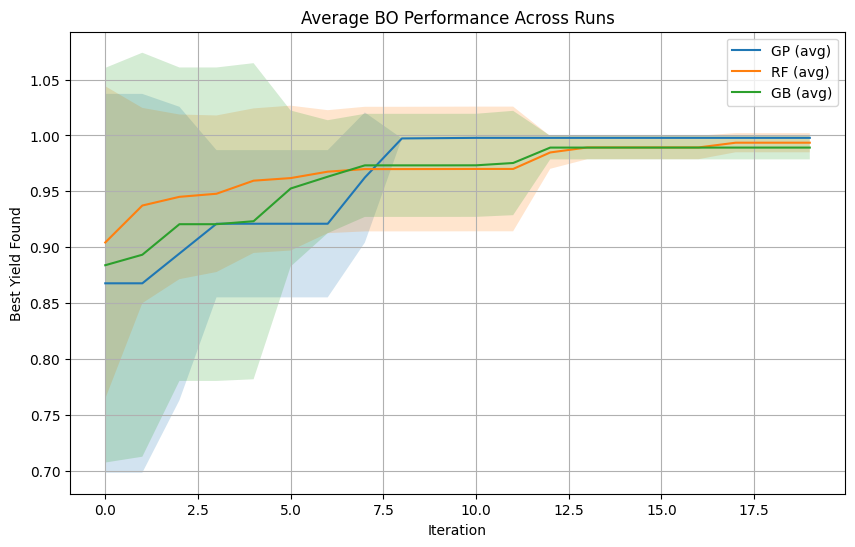


=== Acquisition Function: UCB ===
Running Gaussian Process BO...
Running Random Forest BO...
Running Gradient Boosting BO...


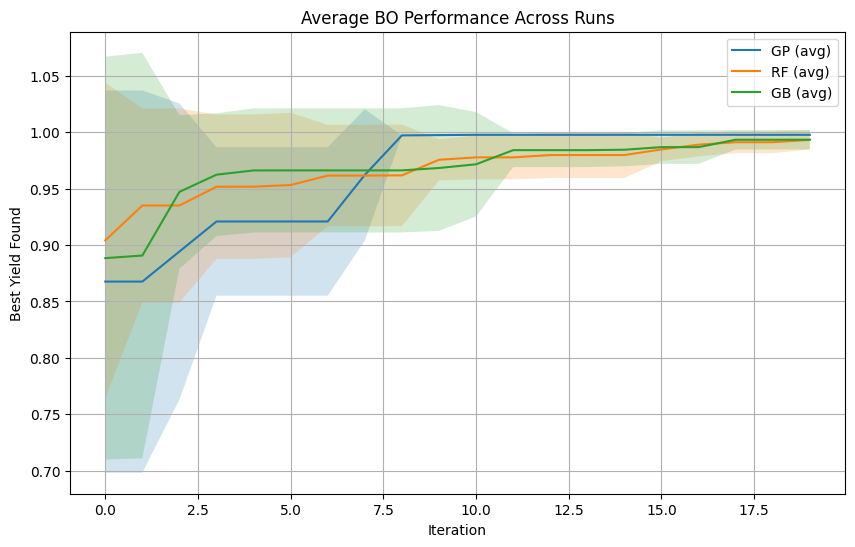


=== Acquisition Function: PI ===
Running Gaussian Process BO...
Running Random Forest BO...
Running Gradient Boosting BO...


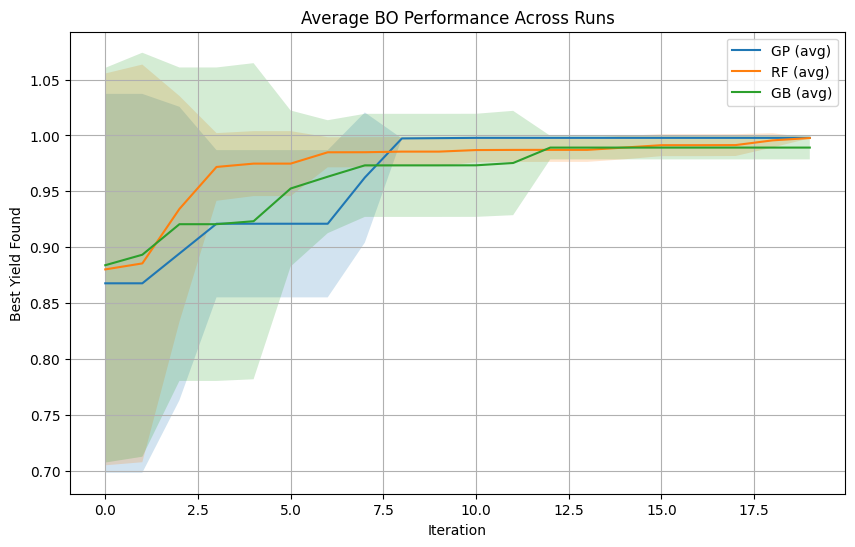

In [78]:
def main():
    X_pool, y_pool = load_data('../all_data.csv')
    n_runs = 10
    n_iterations = 20

    gp = GaussianProcessRegressor(kernel=C(1.0) * RBF(), alpha=1e-6, normalize_y=True)
    rf = RandomForestRegressor(n_estimators=100)
    gb = GradientBoostingRegressor(n_estimators=100)

    acq_funcs = ['ei', 'ucb', 'pi']

    for acq in acq_funcs:
        print(f"\n=== Acquisition Function: {acq.upper()} ===")
        results = {}
        print("Running Gaussian Process BO...")
        results['GP'] = run_multiple_bo(X_pool, y_pool, gp, n_runs, n_iterations, acq_func=acq)
        print("Running Random Forest BO...")
        results['RF'] = run_multiple_bo(X_pool, y_pool, rf, n_runs, n_iterations, acq_func=acq)
        print("Running Gradient Boosting BO...")
        results['GB'] = run_multiple_bo(X_pool, y_pool, gb, n_runs, n_iterations, acq_func=acq)

        plot_results_besty(results, n_iterations)
if __name__ == "__main__":
    main()

